In [1]:
import warnings
warnings.filterwarnings('ignore')
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn.decomposition import NMF
from os import listdir, getcwd
from os.path import isfile, join
import os
from PIL import Image, ImageOps

# Data Description
The dataset contain images of celebrities.There are 13233 total images, they are separated by the name in directory. I will perform NMF on the dataset to reduce it's dimesionality and then find similar images.

# Main objectives
1. Performing different unsupervised machine learning model.
2. finding similar images.
3. Selecting the best method

# Data cleaning and Feature Engineering
This function will first go to the path of the folder then it will get all the file names in a list if there are any unnecessary file that will be removed. Shuffle the list so that we can get mixture of images for train and test set.After that the images will be resize and converted to array and appended to the dataset.

In [9]:
def get_data_matrix(test=False, length=100, width=100, mypath='/kaggle/input/lfw-image/lfw'):
    files = list()
    for root,dirs,file in os.walk(mypath):
        for f in file:
            files.append(join(root,f))
    if mypath + '/.DS_Store' in files:
        files.remove(mypath + '/.DS_Store')
        
    len_ = len(files)
    np.random.shuffle(files)
    if test:
        print('test_data')
        files = files[10000:len_]
    else:
        print('training data')
        files = files[:10000]
    
    X=np.zeros((len(files),length*width))
    for i,file in enumerate(files):
        img = Image.open(file).resize((width, length))
        img =  ImageOps.grayscale(img)

        I=np.array(img)
 
        X[i,:]=I.reshape(1,-1)
    return X


this function will plot the image

In [3]:
def reshape_row(X,length=100,width=100):
    plt.imshow(X.reshape(width,length),cmap='gray')

In [4]:
def threshold(similar_distance, max_=0.1, min_=0):
    dataset_index = np.where(np.logical_and(similar_distance>min_, similar_distance<max_))[0]
    query_index = similar_index[np.logical_and(similar_distance>min_, similar_distance<max_)]
    return dataset_index,query_index

In [5]:
def plot_data_query(dataset_index,query_index,N):
    for data_sample, query_sample in zip(dataset_index[:N],query_index[:N]):
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        reshape_row(X[data_sample])
        plt.title(f"Sample image {data_sample}")
        plt.subplot(1,2,2)
        reshape_row(X[query_sample])
        plt.title(f"Query image {query_sample}")
        plt.show()
        print("-----------------")

In [10]:
X= get_data_matrix()
X.shape

training data


(10000, 10000)

**First taking 5 component of Non Negative Matrix Factorization**

In [11]:
n_components=5

In [12]:
nmf_estimator = NMF(n_components=n_components,tol=5e-3,max_iter=2000)
nmf_estimator.fit(X)

NMF(max_iter=2000, n_components=5, tol=0.005)

In [13]:
H = nmf_estimator.components_

**We will plot the 5 components**

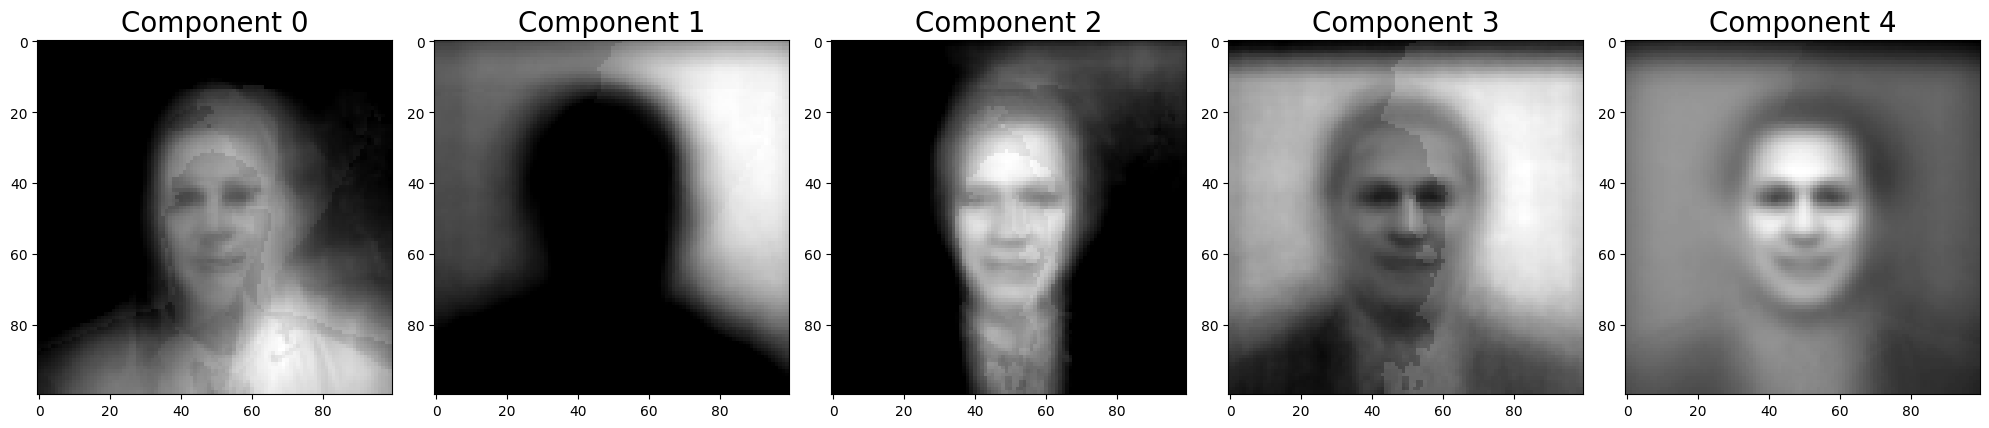

In [14]:
plt.figure(figsize=(20,10))

for i,data in enumerate(H):
    plt.subplot(1,5,i+1)
    reshape_row(data)
    plt.title(f"Component {i}",fontsize=20)
    
plt.tight_layout()

We transform the main dataset so that noise can be removed

In [15]:
W = nmf_estimator.transform(X)

In [16]:
W.shape

(10000, 5)

Lets see the image encoding for the first image

Text(0.5, 1.0, 'Encoding for image 1')

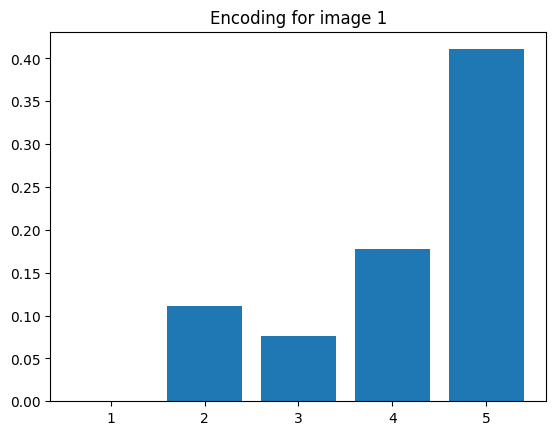

In [17]:
i=0
one = W[i,:]

plt.bar([n+1 for n in range(len(one))],one)
plt.title(f"Encoding for image {i+1}")

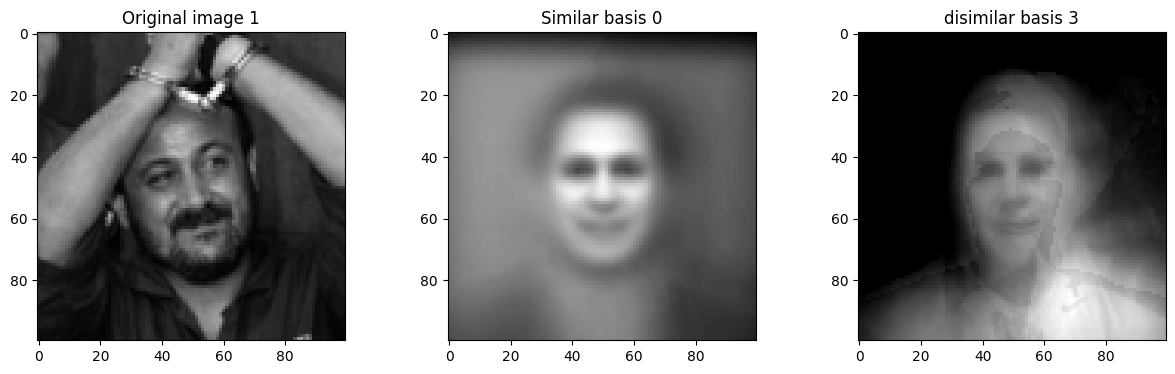

In [19]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
reshape_row(X[i,:])
plt.title(f"Original image {i+1}")
plt.subplot(1,3,2)
reshape_row(H[4])
plt.title(f"Similar basis 0")
plt.subplot(1,3,3)
reshape_row(H[0])
plt.title(f"disimilar basis 3")
plt.show()

In [20]:
Xhat = nmf_estimator.inverse_transform(W)

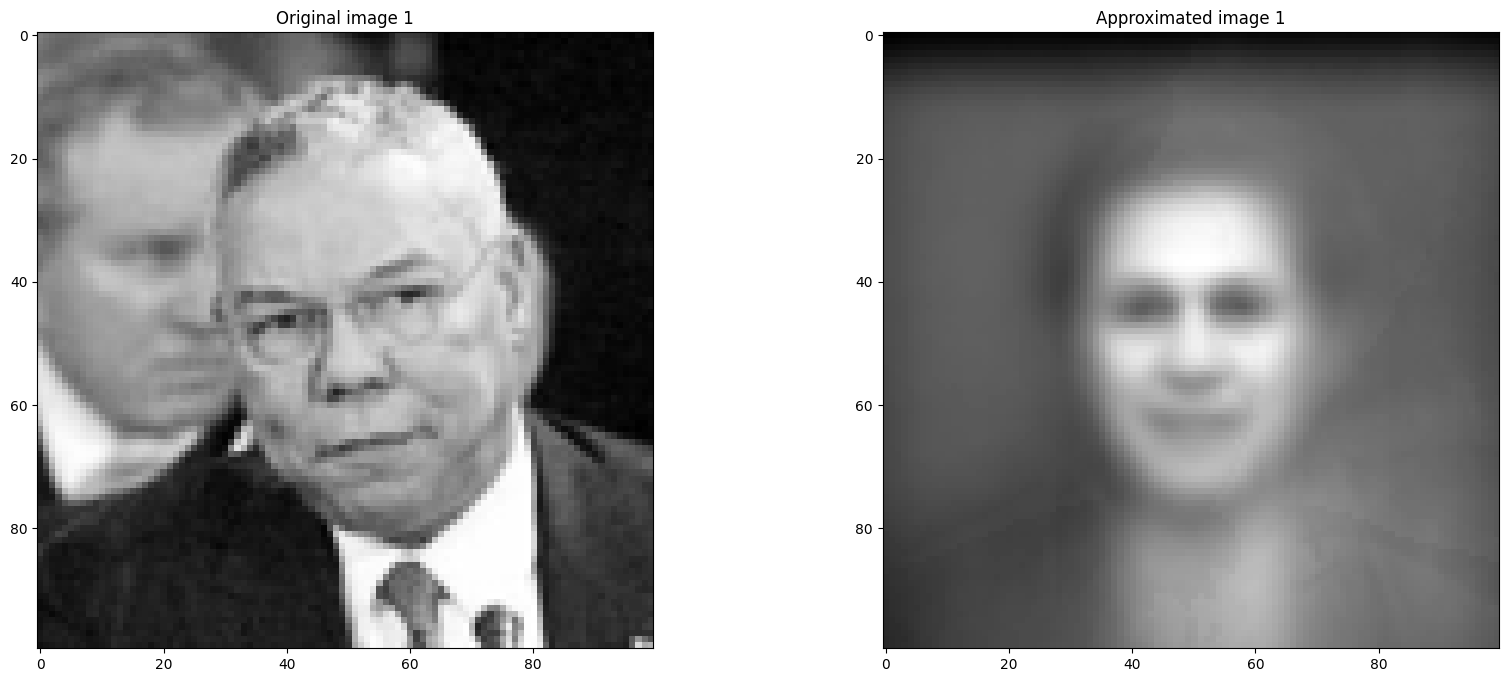

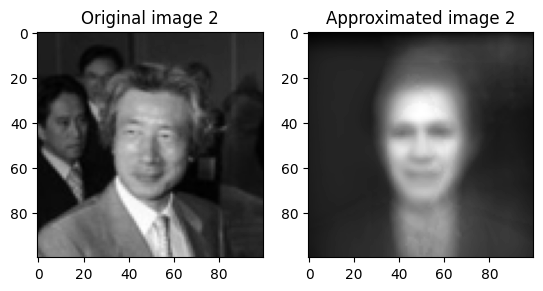

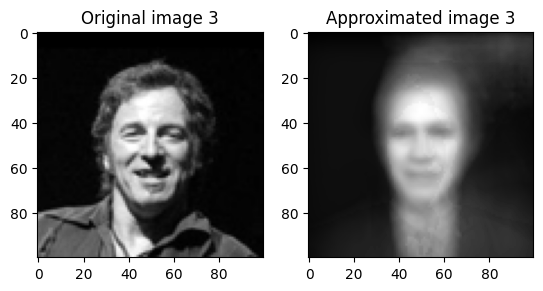

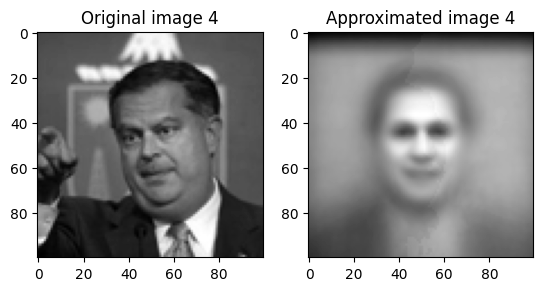

In [21]:
plt.figure(figsize=(20,8))
for i in range(1,5):
    plt.subplot(1,2,1)
    reshape_row(X[i])
    plt.title(f"Original image {i}")
   
    plt.subplot(1,2,2)
    reshape_row(Xhat[i])
    plt.title(f"Approximated image {i}")
    plt.show()

Now we add the 5 component one by one for the first image

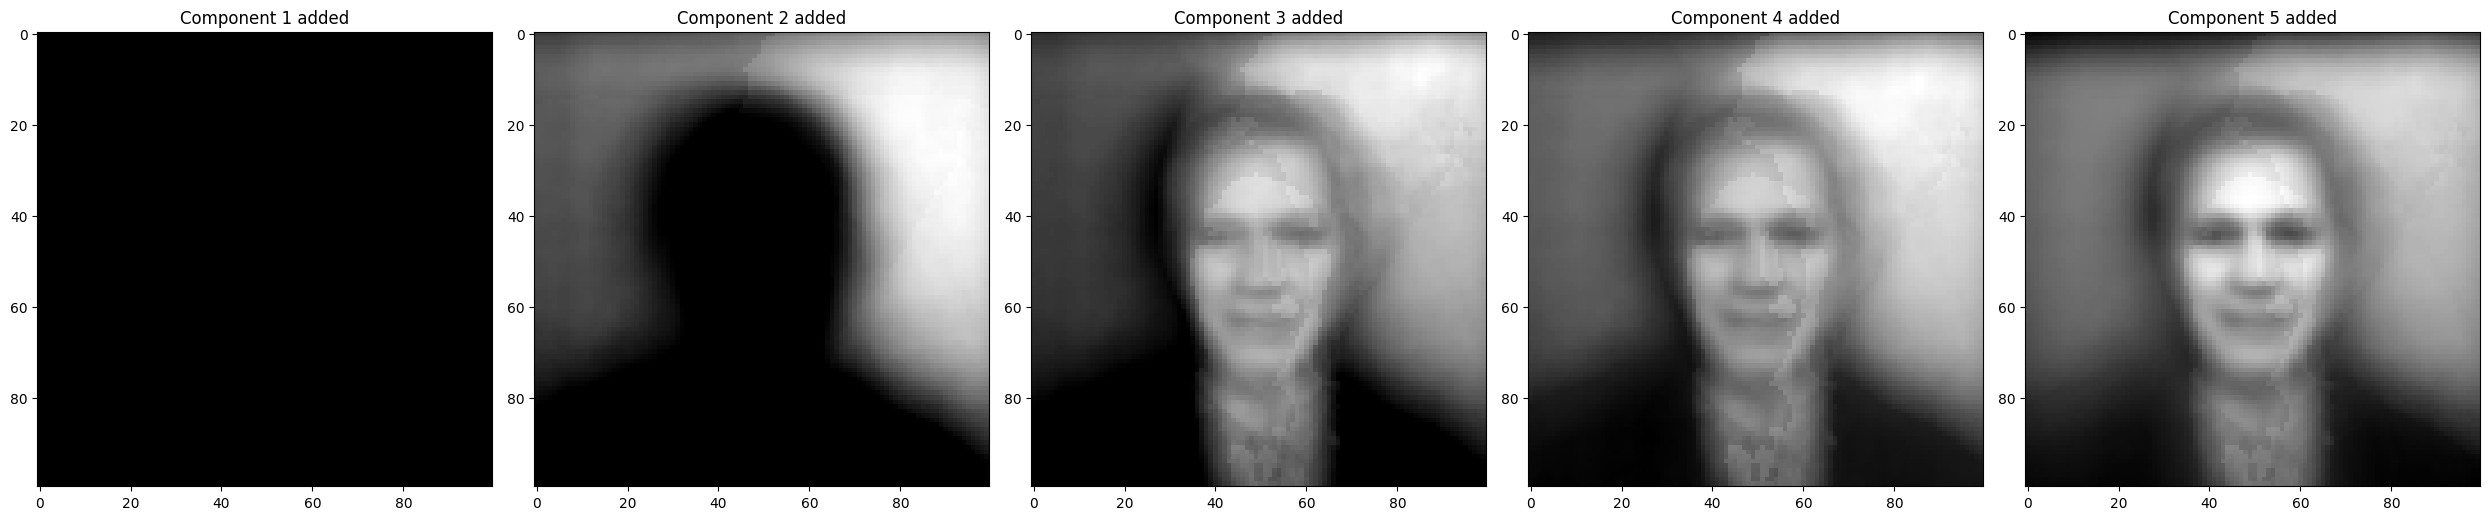

In [22]:
image = np.zeros((1,10000))

plt.figure(figsize=(25,10))
for i,(w_,h) in enumerate(zip(one,H)):
    plt.subplot(1,5,i+1)
    image += w_*h
    reshape_row(image)
    plt.title(f"Component {i+1} added")
plt.tight_layout()

In [24]:
X_q = get_data_matrix(test=True)
X_q.shape

test_data


(3233, 10000)

Transforming the test dataset also

In [25]:
W_q = nmf_estimator.transform(X_q)
W_q.shape

(3233, 5)

In [26]:
from sklearn.metrics import pairwise_distances

we use cosine similarity to find the similar image

In [27]:
distance = pairwise_distances(W,W_q,metric='cosine')
distance.shape

(10000, 3233)

In [28]:
similar_index = np.argmin(distance,axis=1)

In [29]:
similar_distance = np.min(distance,axis=1)

Text(0.5, 1.0, 'Distance Values')

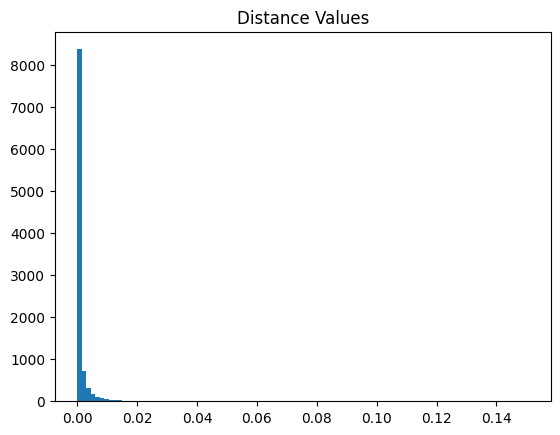

In [30]:
plt.hist(similar_distance, bins=100)
plt.title("Distance Values")

In [82]:
dataset_index,query_index = threshold(similar_distance,max_=1.2e-16,min_=0)


In [83]:
dataset_index.shape,query_index.shape

((33,), (33,))

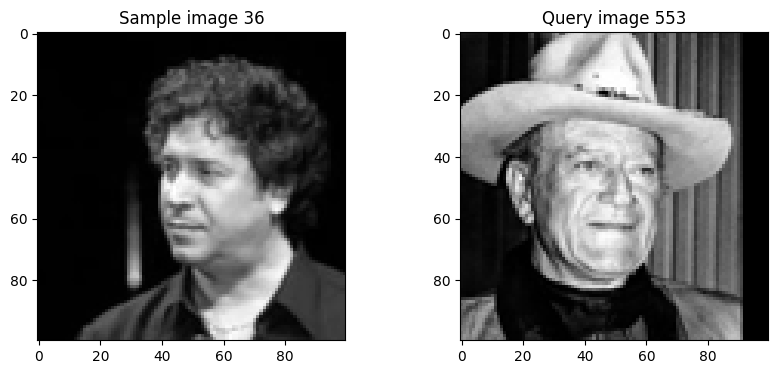

-----------------


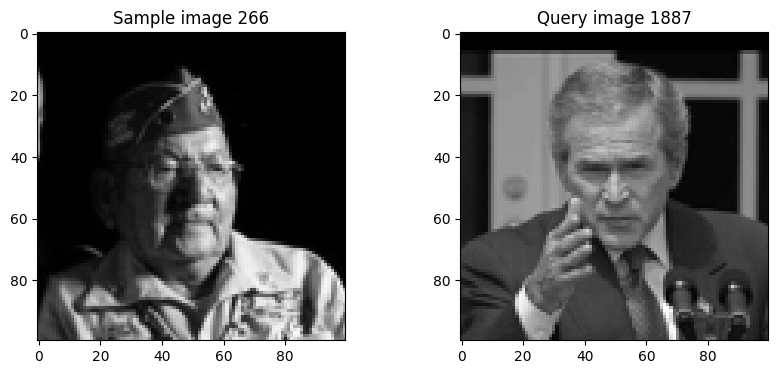

-----------------


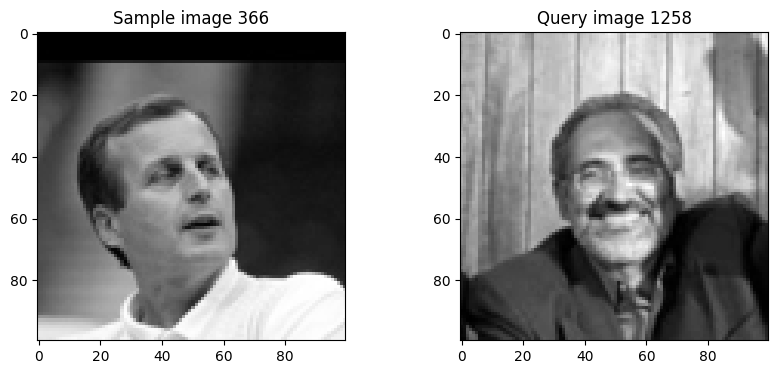

-----------------


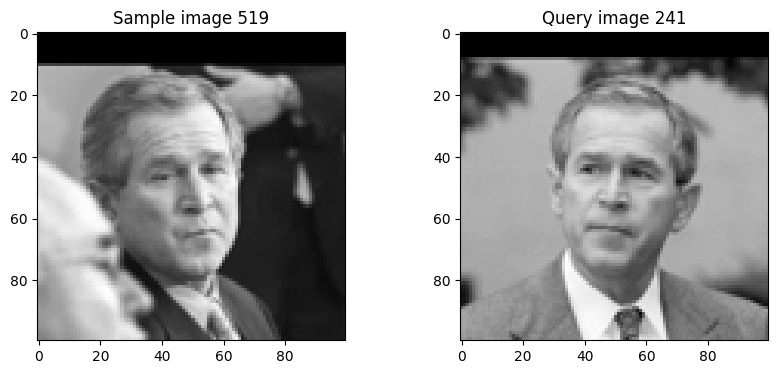

-----------------


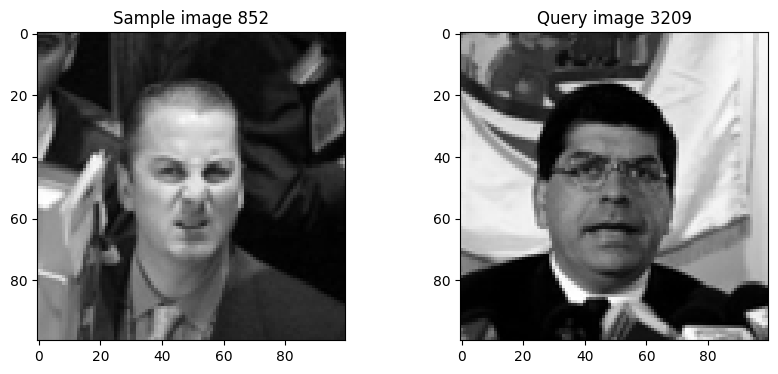

-----------------


In [84]:
plot_data_query(dataset_index,query_index,5)

Now lets see with 10 components

In [85]:
n_components=10

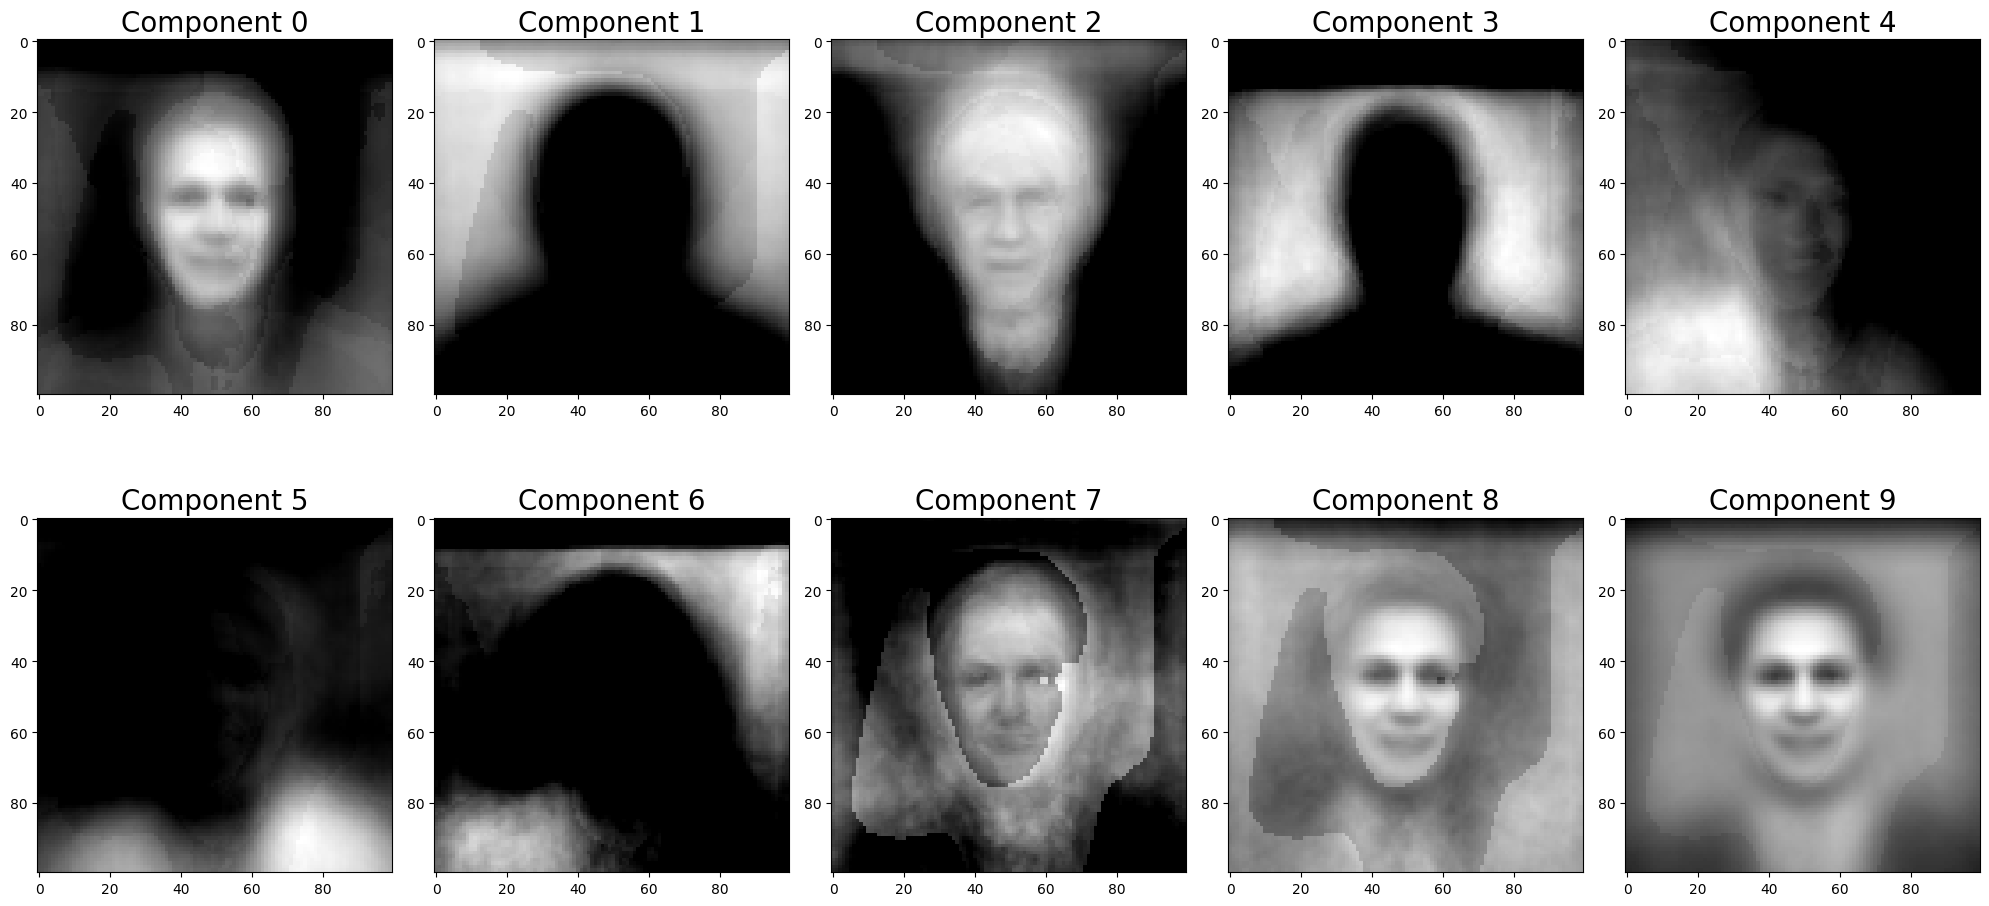

In [88]:
nmf_estimator2 = NMF(n_components=n_components,tol=5e-3,max_iter=2000)
nmf_estimator2.fit(X)
H = nmf_estimator2.components_
plt.figure(figsize=(20,10))

for i,data in enumerate(H):
    plt.subplot(2,5,i+1)
    reshape_row(data)
    plt.title(f"Component {i}",fontsize=20)
    
plt.tight_layout()

In [89]:
W = nmf_estimator2.transform(X)

Text(0.5, 1.0, 'Encoding for image 1')

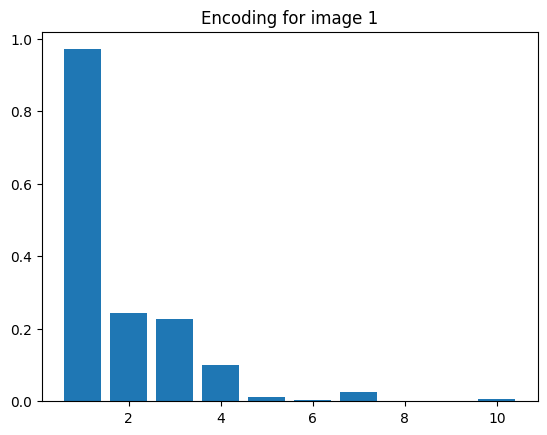

In [90]:
i=0
one = W[i,:]

plt.bar([n+1 for n in range(len(one))],one)
plt.title(f"Encoding for image {i+1}")

In [92]:
Xhat = nmf_estimator2.inverse_transform(W)

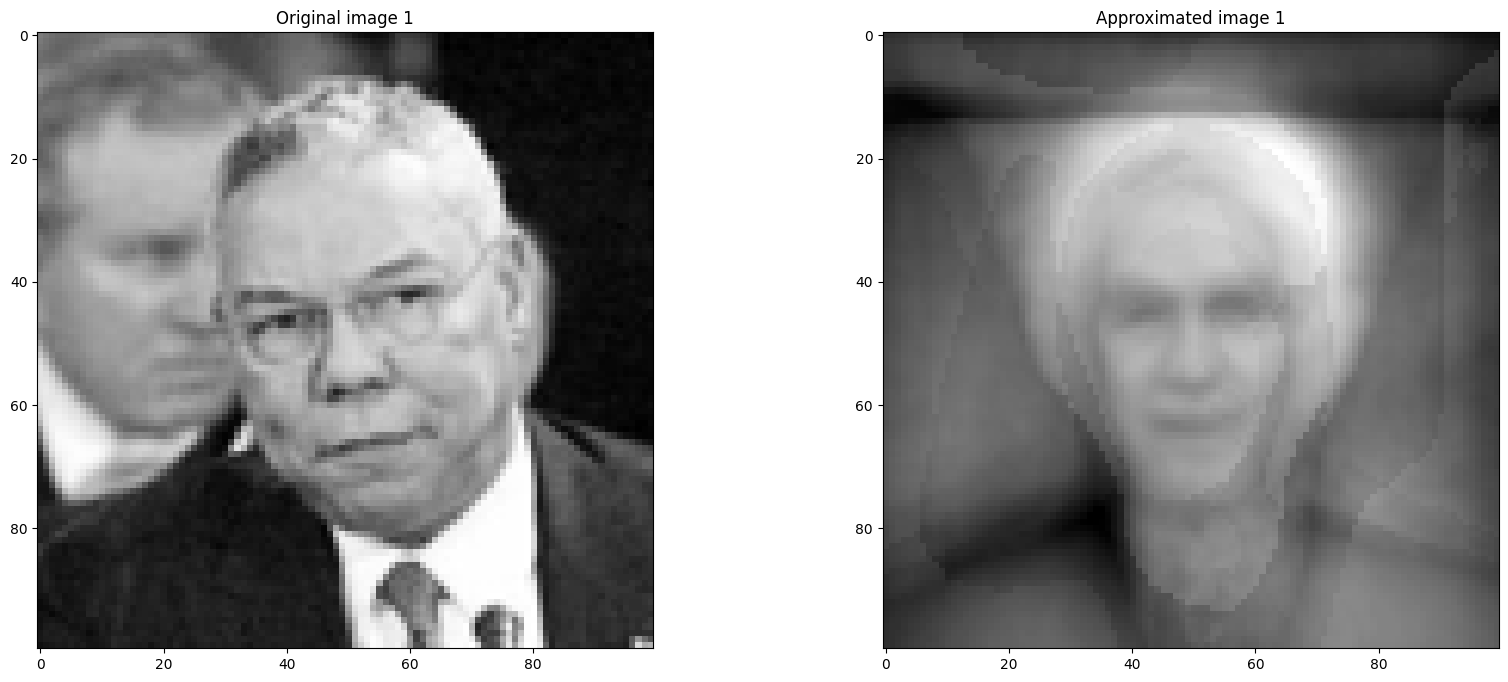

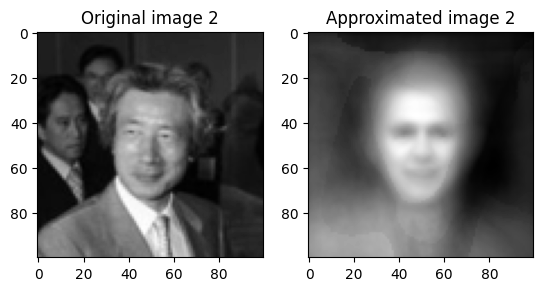

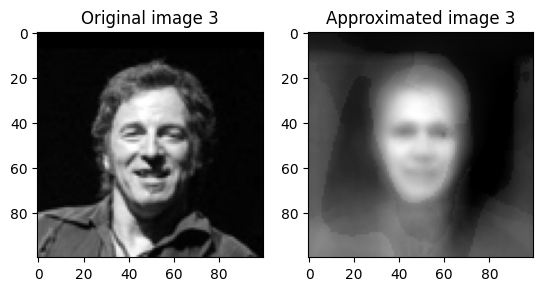

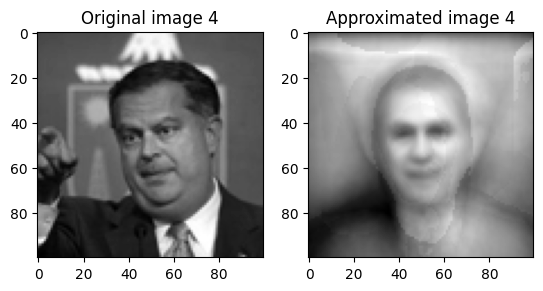

In [93]:
plt.figure(figsize=(20,8))
for i in range(1,5):
    plt.subplot(1,2,1)
    reshape_row(X[i])
    plt.title(f"Original image {i}")
   
    plt.subplot(1,2,2)
    reshape_row(Xhat[i])
    plt.title(f"Approximated image {i}")
    plt.show()

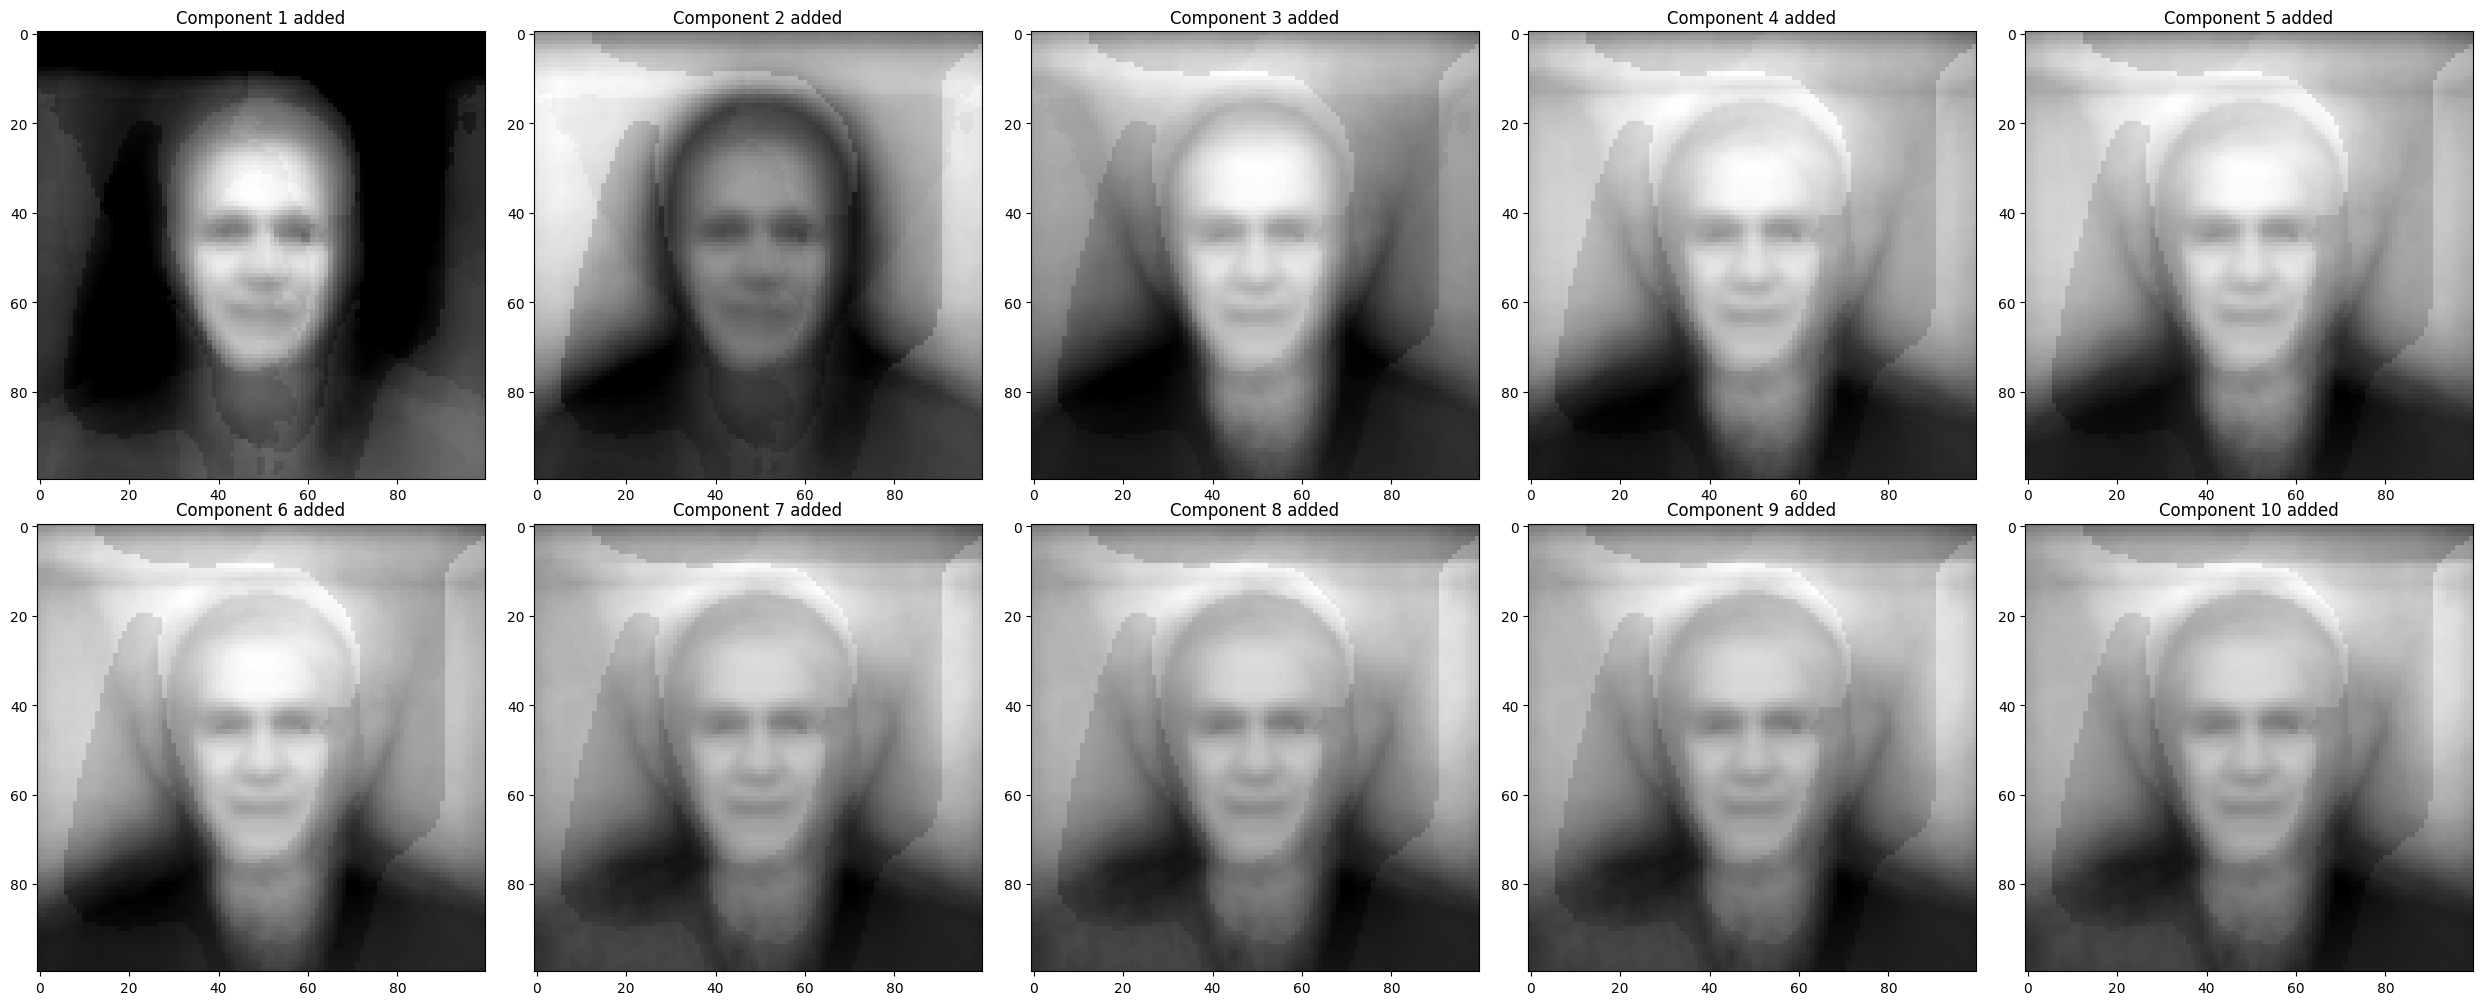

In [95]:
image = np.zeros((1,10000))

plt.figure(figsize=(25,10))
for i,(w_,h) in enumerate(zip(one,H)):
    plt.subplot(2,5,i+1)
    image += w_*h
    reshape_row(image)
    plt.title(f"Component {i+1} added")
plt.tight_layout()

In [96]:
W_q = nmf_estimator2.transform(X_q)
W_q.shape

(3233, 10)

Text(0.5, 1.0, 'Distance Values')

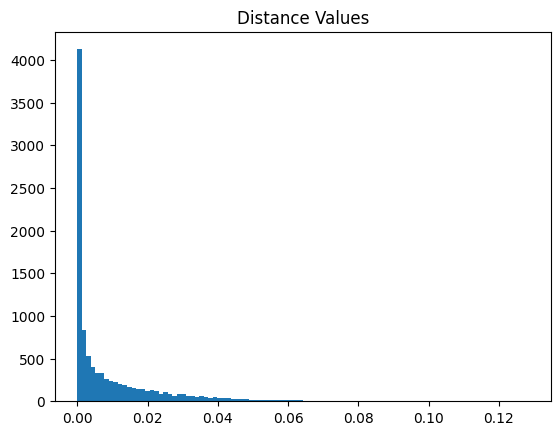

In [97]:
distance = pairwise_distances(W,W_q,metric='cosine')
similar_index = np.argmin(distance,axis=1)
similar_distance = np.min(distance,axis=1)
plt.hist(similar_distance, bins=100)
plt.title("Distance Values")

In [102]:
dataset_index,query_index = threshold(similar_distance,max_=1.12e-16,min_=0)
dataset_index.shape,query_index.shape


((83,), (83,))

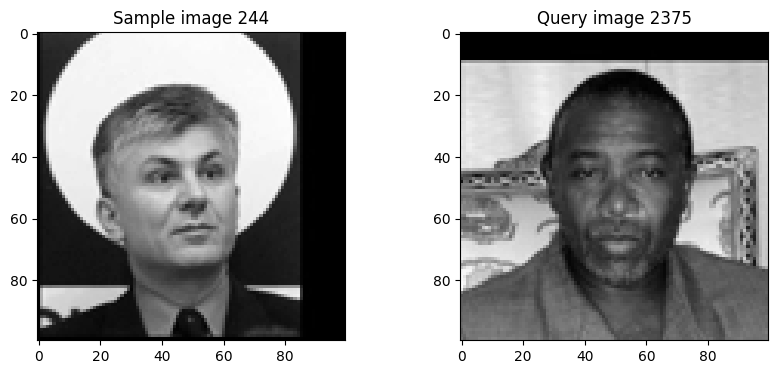

-----------------


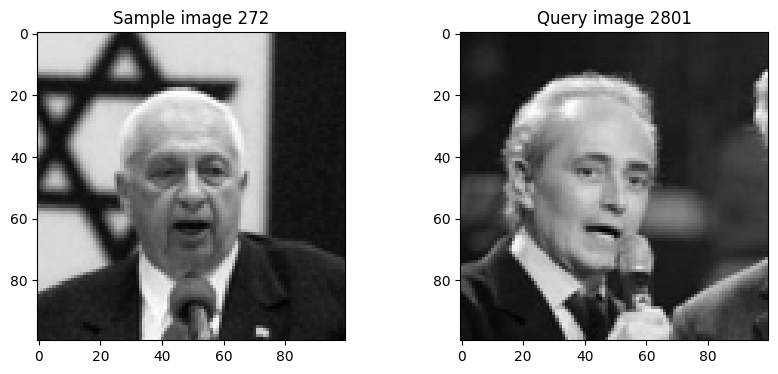

-----------------


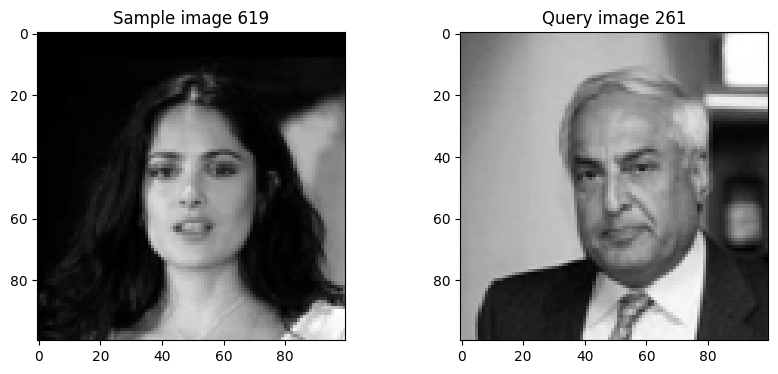

-----------------


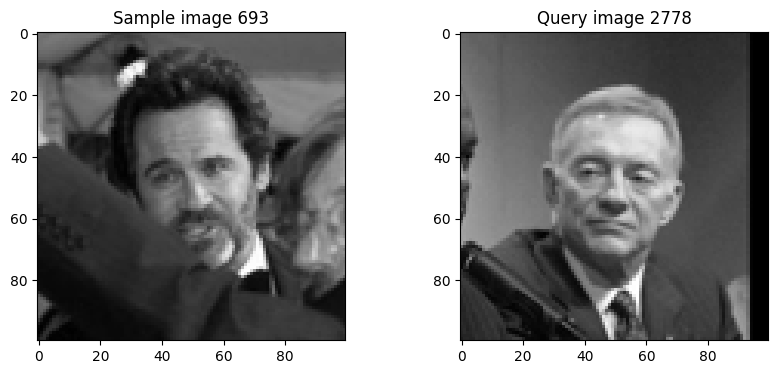

-----------------


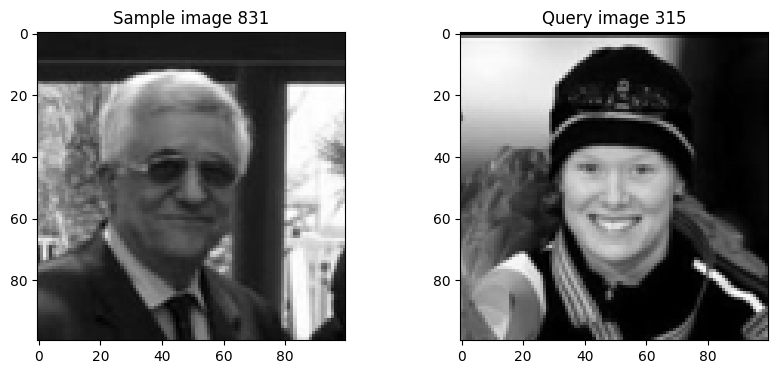

-----------------


In [103]:
plot_data_query(dataset_index,query_index,5)

# Decision
with only 5 component it performs better
# Summary
* Dimensionality reduction can improve the model performance very much
* As the dataset has background details either than the only face so it also matches these extra details also that's why our result is not very accurate
* By only doing these steps we can not ensure accurate result.
# Suggestion
* To improve the result background and all other parts of body can be cropped and only focus the face
* Also deep learning model will perform better
